In [1]:
from utils import *
from preprocessing import *
from cnn_model import *
SIZE = 256

/home/jingxi/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
'''
# loading data and pre-process

'''
# original image, binary mask, contour(self-defined class)
img_train, mask_train, contour_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test, contour_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val, contour_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

#Region of interest, aka bounding box computed from the contour
ROI_train = get_ROI(contour_train)
ROI_test = get_ROI(contour_test)
ROI_val = get_ROI(contour_val)

#Re-organize the data for CNN
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)


In [3]:
#Get the result from the first step (CNN):

cnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}
y_pred = run_cnn(cnn_data)
cropped = get_cropped(img_test, y_pred, win_size = 100)

print(y_pred.shape)

(279, 1, 32, 32)


In [8]:
#Get result from Stacked AE
def get_mask_pred(img,y_pred):
    n = img.shape[0]
    mask_contour = np.zeros((n, 80, 80, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_contour[i] =  img[i][x_min:x_max, y_min:y_max]   
    return mask_contour

mask_contour =get_mask_pred(mask_test,y_pred)
print(mask_contour.shape)

def open_data_AE(y_pred):
    """
    Open dataset from the output of the CNN and
    unroll it as 64*64 = vector of 4096 elements
    :param y_pred: CNN output
    :return: input AE, output
    """
    input_AE = []
    contour_experts = []
    for j in range(y_pred.shape[0]):
        in_AE = cv2.resize(cropped[j],(64 , 64))
        contour = cv2.resize(mask_contour[j], (64,64), interpolation = cv2.INTERSECT_NONE)
        input_AE.append(in_AE)
        contour_experts.append(contour)
    return np.array(input_AE).reshape((-1, 64*64)), np.array(contour_experts).reshape((-1, 64*64))

X_train, Y_train = open_data_AE(y_pred)
X_train.shape, Y_train.shape
from StackedAeModel import SAE
#apply stacked auto encoder to preprocessed data
h, model = SAE(X_train,Y_train)

(279, 80, 80, 1)


/home/jingxi/.local/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [9]:
def prediction_plot(X, model, idx):
    """
    Compute the Inferred shape binary mask using the trained stacked AE model
    :param X: dataset to predict
    :param model: trained AE model
    :param idx: index of the particular picture to return
    :return: inferred shape binary mask, infered shape on the MR image
    """
    contours = model.predict(X)
    contour = contours[idx].reshape((64,64))
    # thresholding
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64)

In [10]:
#n is number of test images
n = img_test.shape[0]
pred_mask,pred_img=[],[]
for i in range(n):
    bin_mask,img = prediction_plot(X_train,model,i)
    pred_mask.append(bin_mask)
    pred_img.append(img)
pred_mask = np.array(pred_mask)
pred_img = np.array(pred_img)
print (pred_mask.shape)

(279, 64, 64)


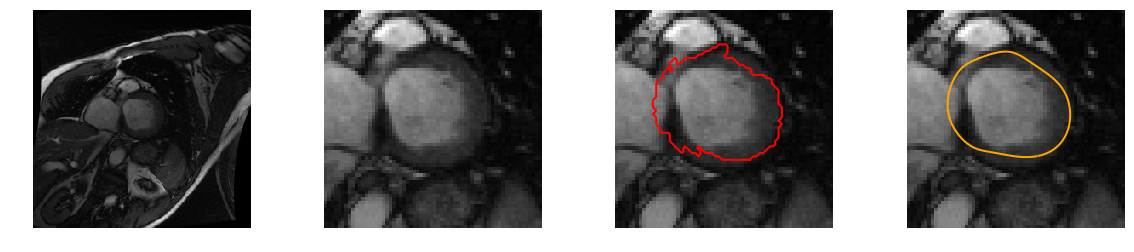

In [11]:
idx = 66
X_input = img_test[idx].reshape((256,256))
X_roi = X_train[idx].reshape((64,64))
bin_pred = pred_mask[idx]

from skimage import measure
contours_pred = measure.find_contours(bin_pred, 0.5)
contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]

f, ax = plt.subplots(ncols=4, figsize=(20,4))


from skimage.segmentation import active_contour
img = X_train[idx].reshape((64,64))
from skimage.filters import gaussian
ac_contour = active_contour(gaussian(img,3), contour_pred, alpha=0.01, beta=0.1, w_edge=0,gamma=0.01,bc='periodic',convergence=0.1)

ax[0].imshow(X_input, cmap='gray')
ax[1].imshow(X_roi, cmap='gray')
ax[2].imshow(img, cmap='gray')
ax[2].plot(contour_pred[:, 1], contour_pred[:, 0], linewidth=2, color='red',label='Prediction')
ax[3].imshow(img, cmap='gray')
ax[3].plot(ac_contour[:, 1], ac_contour[:, 0], linewidth=2, color='orange',label='Prediction')
for i in range(4):
    ax[i].axis('off')